# Food Vision 101

Predict the food class out of a 101 classes

In [1]:
# Check for GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-6af0b6a0-3144-2a78-a5d3-e8f506dfef7f)


## Get the helper functions


In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-01-22 12:18:19--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-01-22 12:18:19 (53.7 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [53]:
from helper_functions import plot_loss_curves, create_tensorboard_callback, compare_historys, confusion_matrix, load_and_prep_image, unzip_data

## Using Tensorflow datasets to downlaod the Data


In [4]:
# Get Tensor flow data sets
import tensorflow_datasets as tfds

In [5]:
# list all availabel datasets
datasets_list = tfds.list_builders() # Get all the available datasets on TFDS
print("food101" in datasets_list) # check if the food101 data is there

True


In [6]:
# Load in the food101 dataset
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True,# data gets returned tuple format (data, label)
                                             with_info=True)

## Exploring the food101 data from TensorFlow datasets

1. Class names
2. The shape of our input data
3. the datatype of our inut data
4. What the labels look like (onehot encoded or label encoded)
5. do the label match class names



In [7]:
# Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [8]:
# Get the class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [9]:
# Take one sample of the train data
train_one_sample = train_data.take(1)
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [10]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape},
  Image Datatype: {image.dtype},
  Target Class from food101: {label},
  class name: {class_names[label.numpy()]}
        """)


  Image shape: (512, 512, 3),
  Image Datatype: <dtype: 'uint8'>,
  Target Class from food101: 18,
  class name: chicken_curry
        


In [11]:
# What does our image tensor look like
import tensorflow as tf
tf.reduce_max(image)

<tf.Tensor: shape=(), dtype=uint8, numpy=255>

### Plot an image from tensorflow datasets

(-0.5, 511.5, 511.5, -0.5)

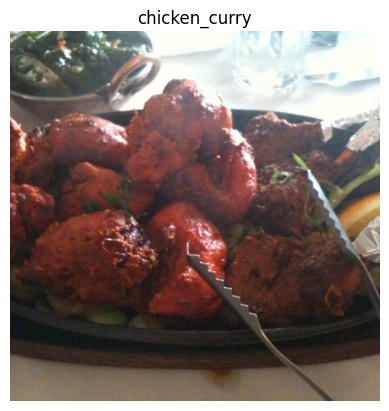

In [12]:
# plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False)

## Create preprocessing functions for our data

Neural Networks perfrom best when data is in a certain way.
However not all data comes like this.
What we know about our data:
1. In `uint8` datatype
2. different size images
3. not scaled (pixel values between 0 and 255)

What we know models like:
1. data in `float32` dtype or mixed percision `float16`
2. Tensorflow likes all of the tensors batch to be the same size
3. Scaled (values between 0 and 1) `normalized` generally perform better



In [13]:
# Make a function for preprocessing iamges
def preprocess_img(image, label, img_shape=224):
  image = tf.image.resize(image, [img_shape, img_shape])
  return tf.cast(image, tf.float32), label #return a (float32_img, label) tuple

In [14]:
# Preprocess a sample
preprocessed_img = preprocess_img(image, label)[0]
preprocessed_img

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[170.5051  , 188.59184 , 163.11736 ],
        [187.9898  , 206.82143 , 186.91837 ],
        [208.97958 , 225.69388 , 212.7653  ],
        ...,
        [253.      , 255.      , 249.      ],
        [253.      , 255.      , 249.      ],
        [253.      , 255.      , 249.      ]],

       [[155.02551 , 149.47958 , 134.38776 ],
        [149.11224 , 149.47958 , 137.11734 ],
        [153.97449 , 162.87245 , 152.42857 ],
        ...,
        [253.      , 255.      , 249.      ],
        [253.      , 255.      , 249.      ],
        [253.      , 255.      , 249.      ]],

       [[126.99999 , 106.21939 ,  99.79082 ],
        [119.591835, 108.19388 , 102.12245 ],
        [118.66837 , 121.42857 , 113.42857 ],
        ...,
        [253.      , 255.      , 249.      ],
        [253.      , 255.      , 249.      ],
        [253.      , 255.      , 249.      ]],

       ...,

       [[139.71938 , 125.71938 ,  98.71938 ],
        [137.

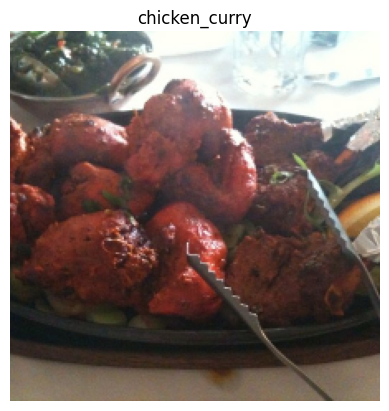

In [15]:
# We can still plot our preprocessed image as long as we
# divide by 255 (for matplotlib capatibility)
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False);

## Batch and prepare datasets

we are now going to make our data input pipleline run really fast.


In [16]:
# Map preprocessing funtion to training data and parallelize it
train_data = train_data.map(map_func=preprocess_img,
                            num_parallel_calls=tf.data.AUTOTUNE,
                            )
# shuffle train data and turn it into batches and prefetch it
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)


# Testing data

# Map preprocessing funtion to testing data and parallelize it
test_data = test_data.map(map_func=preprocess_img,
                            num_parallel_calls=tf.data.AUTOTUNE,
                            )
# shuffle train data and turn it into batches and prefetch it
test_data = test_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [17]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Creating modelling callbacks

In [19]:
# Create a tensorboard callback (import from helper_functions)
from helper_functions import create_tensorboard_callback

# Create a modelcheckpoint callback

checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

In [20]:
tf.__version__

'2.15.0'

## Set up mixed percision (float32 and float16 together)

In [21]:
# Turn on mixed percision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16") # set global data policy to mixed percision

## Build Feature extraction model


In [24]:
from tensorflow.keras import layers
input_shape  = (224,224,3)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=input_shape, name="input_layer")

x = base_model(inputs, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

x = layers.Dense(len(class_names))(x)

outputs = layers.Activation("softmax", dtype=tf.float32)(x)

# Make a model with inputs and outputs
model = tf.keras.Model(inputs, outputs)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"]
              )
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 dense_1 (Dense)             (None, 101)               129381    
                                                                 
 activation (Activation)     (None, 101)               0         
                                                             

In [28]:
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)


input_layer True float32 <Policy "float32">
efficientnetv2-b0 False float32 <Policy "mixed_float16">
global_average_pooling_layer True float32 <Policy "mixed_float16">
dense_1 True float32 <Policy "mixed_float16">
activation True float32 <Policy "float32">


## Fit the model

In [29]:
history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=3,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15*len(test_data)),
                                                     callbacks=[create_tensorboard_callback("training_logs",
                                                                                            "efficientnetB0_101_classes_all_data_feature_extract",
                                                                                          ),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetB0_101_classes_all_data_feature_extract/20240122-132557
Epoch 1/3
2368/2368 [==============================] - 201s 78ms/step - loss: 1.7439 - accuracy: 0.5761 - val_loss: 1.1453 - val_accuracy: 0.6970
Epoch 2/3
2368/2368 [==============================] - 194s 81ms/step - loss: 1.2110 - accuracy: 0.6866 - val_loss: 1.0235 - val_accuracy: 0.7233
Epoch 3/3
2368/2368 [==============================] - 182s 76ms/step - loss: 1.0634 - accuracy: 0.7230 - val_loss: 1.0059 - val_accuracy: 0.7315


In [30]:
results_model_feature_extract = model.evaluate(test_data)
results_model_feature_extract

790/790 [==============================] - 59s 71ms/step - loss: 0.9984 - accuracy: 0.7307


[0.9983884692192078, 0.7306930422782898]

## Fine tune the model

In [31]:
for layer in model.layers:
    layer.trainable = True

In [32]:
# Lets create some callbacks
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

In [33]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down
                                                 min_lr=1e-7)

In [34]:
# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"])

In [35]:
history_101_food_classes_all_data_fine_tune = model.fit(train_data,
                                                        epochs=100, # fine-tune for a maximum of 100 epochs
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                                        callbacks=[create_tensorboard_callback("training_logs", "efficientb0_101_classes_all_data_fine_tuning"), # track the model training logs
                                                                   model_checkpoint, # save only the best model during training
                                                                   early_stopping, # stop model after X epochs of no improvements
                                                                   reduce_lr])

Saving TensorBoard log files to: training_logs/efficientb0_101_classes_all_data_fine_tuning/20240122-134844
Epoch 1/100
2368/2368 [==============================] - 437s 157ms/step - loss: 0.8696 - accuracy: 0.7658 - val_loss: 0.7792 - val_accuracy: 0.7842 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - 374s 157ms/step - loss: 0.5115 - accuracy: 0.8582 - val_loss: 0.7181 - val_accuracy: 0.8106 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - 338s 142ms/step - loss: 0.2667 - accuracy: 0.9229 - val_loss: 0.8141 - val_accuracy: 0.7926 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - ETA: 0s - loss: 0.1344 - accuracy: 0.9600
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 330s 139ms/step - loss: 0.1344 - accuracy: 0.9600 - val_loss: 0.9141 - val_accuracy: 0.7908 - lr: 1.0000e-04
Epoch 5/100
2368/2368 [==============================] - 329s 13

In [44]:
model.evaluate(test_data)

790/790 [==============================] - 71s 87ms/step - loss: 0.9819 - accuracy: 0.8109


[0.981915295124054, 0.8108910918235779]

--2024-01-22 14:37:16--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.159.207, 142.251.120.207, 142.251.161.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.159.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip.1’

custom_food_images. 100%[===================>]  12.58M  --.-KB/s    in 0.05s   

2024-01-22 14:37:16 (258 MB/s) - ‘custom_food_images.zip.1’ saved [13192985/13192985]

1/1 [==============================] - 0s 35ms/step


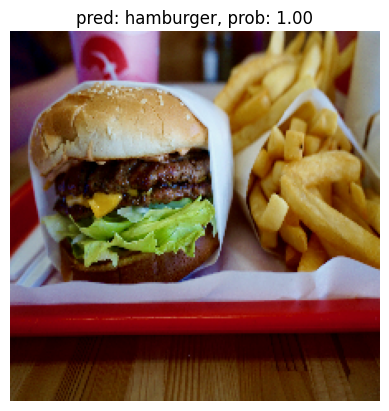

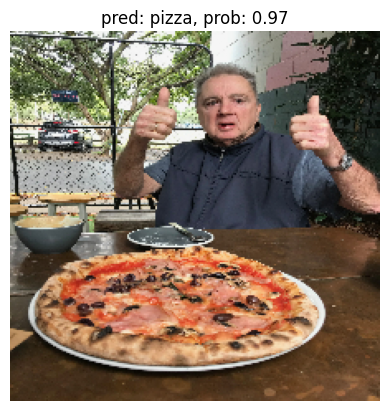

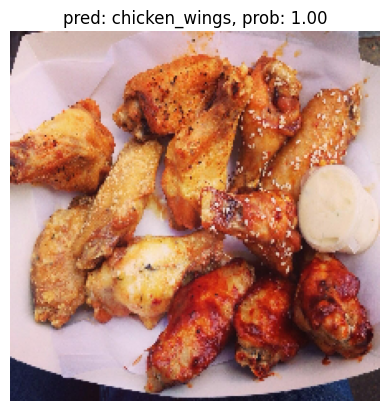

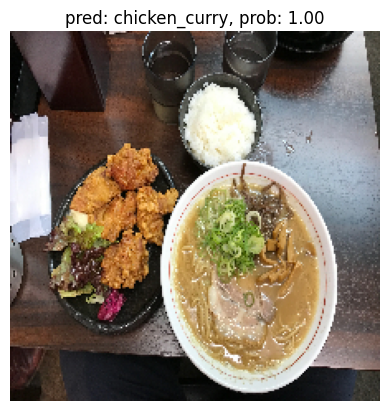

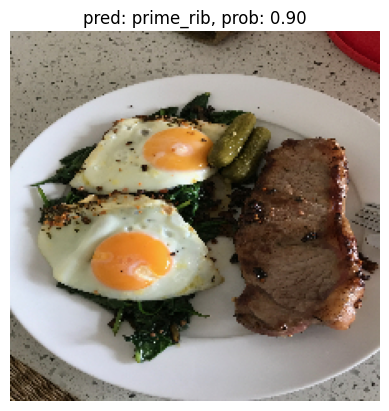

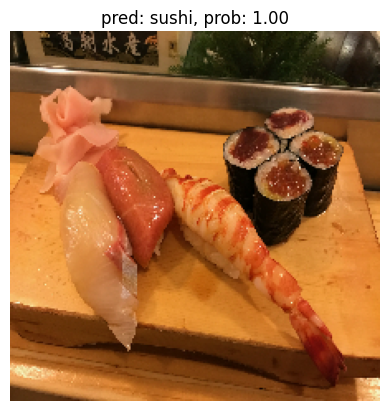

In [54]:
# Download some custom images from Google Storage
# Note: you can upload your own custom images to Google Colab using the "upload" button in the Files tab
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

unzip_data("custom_food_images.zip")
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]

# Make predictions on custom food images
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False) # load in target image and turn it into tensor
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class label
  # Plot the image with appropriate annotations
  plt.figure()
  plt.imshow(img/255.) # imshow() requires float inputs to be normalized
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)

# Model prediction = **81%**